# Training using Keras Neural Network Base Template

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error,r2_score
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers, callbacks, Input
pd.options.display.max_columns = None

## Functions

In [2]:
def split_and_scale_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return scaler, X_train, X_test, y_train, y_test

In [3]:
def get_sequential_model(model_params, features_input, features_output):
    ''' Input a model params dict with optimizer, loss function, number of units 
    per hidden layer, no. of hidden layers, activation layer, and epochs.'''
    model = Sequential()
    model.add(Input(shape=(len(features_input),)))
    for i in range (0,model_params['hidden_layers']):
        model.add(Dense(model_params['units'], activation= model_params['activation']))
    model.add(Dense(len(features_output), activation= model_params['activation']))
    model.compile(optimizer= model_params['optimizer'], loss= model_params['loss'])
    return model

In [4]:
def plot_losses(loss_df, start, end):
    ''' use start and end to zoom into plot, from 0 to 1.0. E.g. 0.1 - 0.2 '''
    plt.figure(figsize=(3,2))
    before_epoch = int(start * len(loss_df))
    after_epoch = int(end * len(loss_df))
    plt.plot(loss_df[before_epoch:after_epoch])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])

In [5]:
def get_test_vs_pred_dataframe(y_test, y_pred, outputs):
    ''' accomodate for multiple outputs '''
    y_pred = pd.DataFrame(data= np.asarray(y_pred))
    pred_df = pd.DataFrame(data= np.asarray(y_test))
    pred_df = pd.concat([pred_df, y_pred], axis=1)
    test_list = ['test_'+feature for feature in outputs]
    pred_list = ['pred_'+feature for feature in outputs]
    pred_df.columns = test_list + pred_list
    return pred_df

In [6]:
def get_score_metrics(pred_df, outputs, round_off):
    ''' form a error and r2 score metrics dataframe of multiple outputs '''
    data_dict = dict()
    for output in outputs:
        test_output = 'test_'+ output
        pred_output = 'pred_'+ output
        mae = round(mean_absolute_error(pred_df[test_output], pred_df[pred_output]),round_off)
        mse = round(mean_squared_error(pred_df[test_output], pred_df[pred_output]),round_off)
        rmse = round(root_mean_squared_error(pred_df[test_output], pred_df[pred_output]),round_off)
        #mape = mean_absolute_percentage_error(pred_df[test_output], pred_df[pred_output]) * 100
        r2 = round(r2_score(pred_df[test_output], pred_df[pred_output]),round_off)
        data_dict[output] = [mae, mse, rmse, r2]
    # form df
    metrics_df = pd.DataFrame(data= data_dict)
    metrics_df.index = ['mae', 'mse', 'rmse', 'r2']
    return metrics_df

In [7]:
def plot_true_vs_pred(pred_df, feature, xy_step=1):
    '''The true vs pred plot includes an y=x line. The step is used for results < 1.'''
    true_feature = 'test_' + feature
    pred_feature = 'pred_' + feature
    sns.lineplot(x= np.arange(min(pred_df[true_feature]), max(pred_df[true_feature]), xy_step), 
                 y= np.arange(min(pred_df[true_feature]), max(pred_df[true_feature]), xy_step), 
                 c='grey')
    ax = sns.scatterplot(x= pred_df[true_feature], y= pred_df[pred_feature])
    #ax.text(1,270,'NN model (co2)\nR2 score: {}'.format(round(r2,3)))

In [8]:
def get_error_columns(pred_df, features_output):
    for feature in features_output:
        test_feature = 'test_'+ feature
        pred_feature = 'pred_'+ feature
        error_column = 'error_percent_'+ feature
        for index in pred_df.index:
            if pred_df.loc[index, test_feature] != 0:
                pred_df.loc[index, error_column] = (pred_df.loc[index,pred_feature] - pred_df.loc[index,test_feature]) *100 / pred_df.loc[index,test_feature]
            else:
                pred_df.loc[index, error_column] = 0
    return pred_df

## Start

In [9]:
df = pd.read_csv('raw_input.csv', index_col=[0])
df.head()

,me1_hrs,me2_hrs,dg1_hrs,dg2_hrs,dg3_hrs,dg4_hrs,cp1_hrs,cp2_hrs,bow_hrs,underway_hrs,distance,fuel_consumed
date,,,,,,,,,,,,
20240401,15.5,7.1,20,0,4,8,8.4,0.0,2.4,7.1,29.0,2.395
20240402,3.7,17.0,19,0,8,1,0.0,13.3,0.8,3.7,25.6,2.131
20240403,4.1,8.8,23,0,2,3,0.0,4.7,1.2,4.1,21.2,1.608
20240404,11.0,12.9,21,0,7,3,0.0,1.9,1.6,11.0,68.4,2.551
20240405,6.6,14.2,18,0,8,2,0.0,7.6,1.4,6.6,48.5,2.594


In [10]:
'''# reduce columns by taking sum or max, min
df['me_hrs'] = df[['me1_hrs', 'me2_hrs']].min(axis=1)
df['dg_hrs'] = df['dg1_hrs'] + df['dg2_hrs'] + df['dg3_hrs'] + df['dg4_hrs']
df['cp_hrs'] = df[['cp1_hrs', 'cp2_hrs']].max(axis=1)
features_input = ['me_hrs', 'dg_hrs','cp_hrs', 'bow_hrs', 'underway_hrs', 'distance']'''

"# reduce columns by taking sum or max, min\ndf['me_hrs'] = df[['me1_hrs', 'me2_hrs']].min(axis=1)\ndf['dg_hrs'] = df['dg1_hrs'] + df['dg2_hrs'] + df['dg3_hrs'] + df['dg4_hrs']\ndf['cp_hrs'] = df[['cp1_hrs', 'cp2_hrs']].max(axis=1)\nfeatures_input = ['me_hrs', 'dg_hrs','cp_hrs', 'bow_hrs', 'underway_hrs', 'distance']"

In [11]:
# feature selection
features_input = list(df.columns.drop('fuel_consumed'))
features_output = ['fuel_consumed']
X = df[features_input].values
y = df[features_output].values
print('%i specimens \n%i features \n%i outputs' %(len(df), len(features_input), len(features_output)))

182 specimens 
11 features 
1 outputs


In [12]:
# Split and scale data
scaler, X_train, X_test, y_train, y_test = split_and_scale_data(X, y)

In [13]:
# Create ML model
model_params = {'units':320, 
                'optimizer':'adam', 
                'loss':'mse', 
                'activation':'relu',
                'hidden_layers': 3,
                'epochs': 1000}
model = get_sequential_model(model_params, features_input, features_output)

In [14]:
# Train model
callbacks = [callbacks.EarlyStopping(monitor='val_loss', 
                                     mode='min', 
                                     patience=50, 
                                     restore_best_weights=True
                                     #filepath='best_model.h5',
                                     #save_best_only=True, 
                                     )
            ]
model.fit(x= X_train, y= y_train, validation_split=0.3, epochs= model_params['epochs'], callbacks=callbacks, verbose=0)
loss_df = pd.DataFrame(model.history.history)

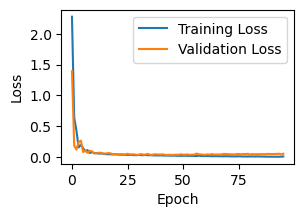

In [15]:
# Plot losses
plot_losses(loss_df, 0, 1)

In [16]:
# Print error metrics
y_pred = model.predict(X_test)
pred_df = get_test_vs_pred_dataframe(y_test, y_pred, features_output)
metrics_df = get_score_metrics(pred_df, features_output, 4)
metrics_df

2/2 [==============================] - 0s 3ms/step


,fuel_consumed
mae,0.1673
mse,0.0544
rmse,0.2332
r2,0.8416


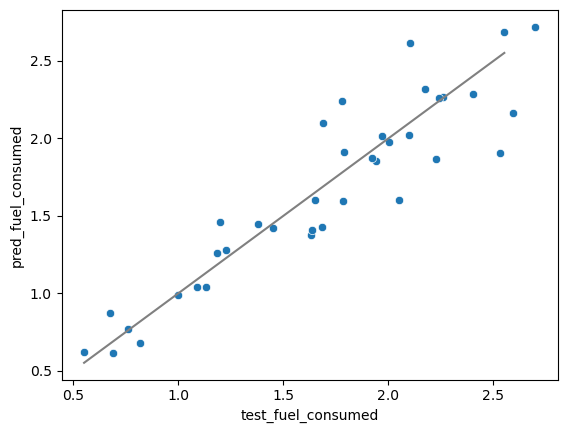

In [17]:
# Plot true vs pred
plot_true_vs_pred(pred_df, 'fuel_consumed', 1)

Text(0.5, 0, 'Percent Error for error_percent_fuel_consumed')

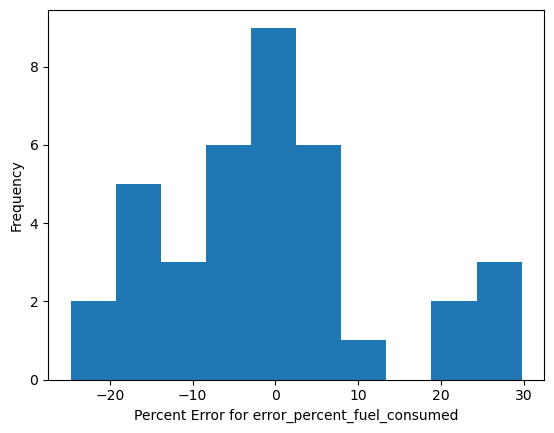

In [18]:
# Plot error hist
pred_df = get_error_columns(pred_df, features_output)
pred_df['error_percent_fuel_consumed'].plot(kind='hist', bins=10)
plt.xlabel('Percent Error for {}' .format('error_percent_fuel_consumed'))

In [19]:
pred_df['error_percent_fuel_consumed'].mean()

-0.4910552783962905

In [20]:
## model saving
#joblib.dump(scaler, 'scaler.gz')
#model.save('model.keras')